In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import sklearn as sl
import seaborn as sns


In [5]:
df = pd.read_csv('train_data.csv')
df

,id,Age,Sex,Health_Index,Fat_Level,Mineral_Ratio,Treatment_Type
0,1,36.0,M,LOW,NORMAL,11.424,4
1,2,16.0,F,HIGH,NORMAL,15.516,0
2,3,18.0,F,NORMAL,NORMAL,8.750,4
3,4,59.0,F,LOW,HIGH,10.444,3
4,5,47.0,M,LOW,NORMAL,18.043,0
...,...,...,...,...,...,...,...
155,156,34.0,M,HIGH,HIGH,18.703,0
156,157,45.0,M,LOW,NORMAL,10.017,4
157,158,52.0,M,LOW,NORMAL,32.922,0
158,159,43.0,M,HIGH,HIGH,13.972,1


In [6]:
#locating null values
df.loc[:].isna().sum()

id                0
Age               0
Sex               0
Health_Index      0
Fat_Level         0
Mineral_Ratio     0
Treatment_Type    0
dtype: int64

In [7]:
#total columns and rows
print("columns = ",len(df.columns))
print("rows = ",len(df.index))
#pretty small data set so we gonna cap the data outliers

columns =  7
rows =  160


In [6]:
#sex and treatment type are not really correlated as p value = 0.8 which is > 0.05 significance level
#Health_Index is highly correlated to treatment as p value <<< 0.05 significance level
#Fat_Level might be somewhat correlated to treatment type as p value is around 0.05. 
        #To prevent underfit we will consider it.

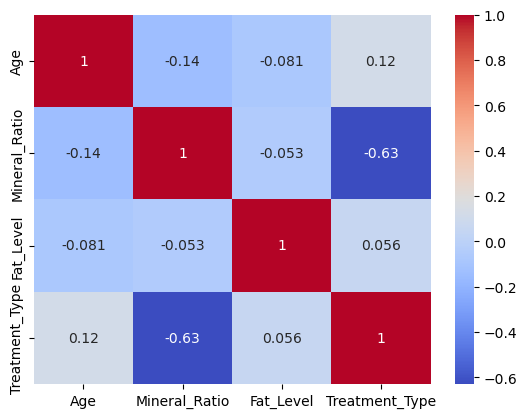

(array([ 1.30146166, 52.9337773 ,  7.62212913]), array([8.61127490e-01, 8.79803679e-11, 1.06442943e-01]))


In [8]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'])
df['Health_Index'] = encoder.fit_transform(df['Health_Index'])
df['Fat_Level'] = encoder.fit_transform(df['Fat_Level'])

X = df[['Sex', 'Health_Index', 'Fat_Level']]
y = df['Treatment_Type']

correlation = df[['Age','Mineral_Ratio','Fat_Level','Treatment_Type']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
pl.show()


chi_scores = chi2(X, y)
print(chi_scores)

In [9]:
#considering columns will be Mineral_Ratio, Health_Index and Fat_Level for prediction
refinedData = df[['Mineral_Ratio','Health_Index','Treatment_Type']]
IQR = refinedData.describe()
IQR

,Mineral_Ratio,Health_Index,Treatment_Type
count,160.000000,160.000000,160.000000
mean,15.778800,0.906250,1.600000
std,6.886081,0.822612,1.694237
min,6.269000,0.000000,0.000000
25%,10.565250,0.000000,0.000000
50%,13.826500,1.000000,1.000000
75%,19.048500,2.000000,4.000000
max,38.247000,2.000000,4.000000


In [10]:
IQR_Range = IQR.loc['75%','Mineral_Ratio'] - IQR.loc['25%','Mineral_Ratio']
lower_1 = IQR.loc['25%','Mineral_Ratio'] - (1.5*IQR_Range)
upper_1 = IQR.loc['75%','Mineral_Ratio'] + (1.5*IQR_Range)
refinedData = refinedData[(refinedData['Mineral_Ratio'] >= lower_1) & (refinedData['Mineral_Ratio'] <= upper_1)]
refinedData

,Mineral_Ratio,Health_Index,Treatment_Type
0,11.424,1,4
1,15.516,0,0
2,8.750,2,4
3,10.444,1,3
4,18.043,1,0
...,...,...,...
154,20.942,1,0
155,18.703,0,0
156,10.017,1,4
158,13.972,0,1


In [11]:
#normalization of numerical data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
refinedData['Mineral_Ratio'] = scaler.fit_transform(refinedData[['Mineral_Ratio']])
refinedData

,Mineral_Ratio,Health_Index,Treatment_Type
0,0.213927,1,4
1,0.383741,0,0
2,0.102959,2,4
3,0.173258,1,3
4,0.488609,1,0
...,...,...,...
154,0.608914,1,0
155,0.515998,0,0
156,0.155538,1,4
158,0.319666,0,1


D:\Siddhi\Projects C_12\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


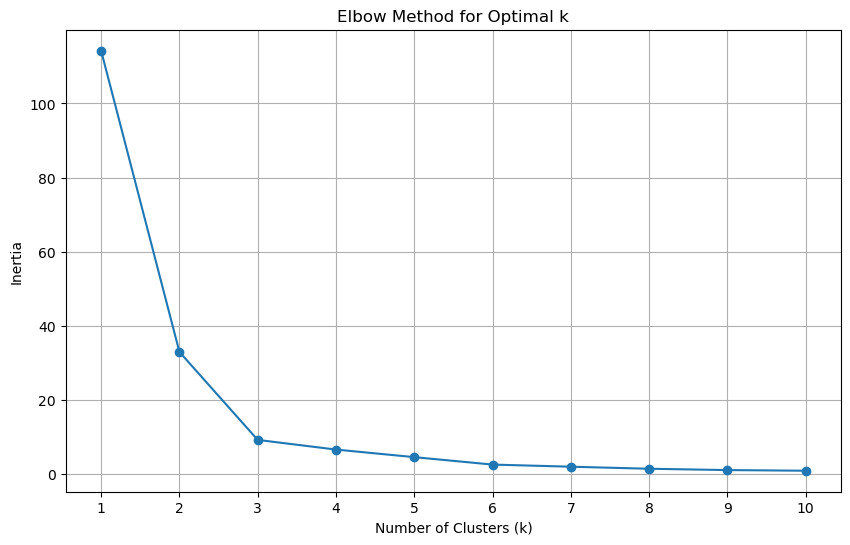

In [13]:


from sklearn.cluster import KMeans

X = refinedData[['Mineral_Ratio','Health_Index']]
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

# Plot the elbow curve
pl.figure(figsize=(10, 6))
pl.plot(k_range, inertia, marker='o')
pl.title('Elbow Method for Optimal k')
pl.xlabel('Number of Clusters (k)')
pl.ylabel('Inertia')
pl.xticks(k_range)
pl.grid()
pl.show()



In [14]:
# Fit K-Means with the chosen number of clusters
k = 4  # Replace with the optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
refinedData['Cluster'] = kmeans.fit_predict(X)  # Adds the cluster assignment
#to DataFrame

# Check the resulting DataFrame with cluster assignments
print(refinedData.head())

   Mineral_Ratio  Health_Index  Treatment_Type  Cluster
0       0.213927             1               4        2
1       0.383741             0               0        3
2       0.102959             2               4        0
3       0.173258             1               3        2
4       0.488609             1               0        2


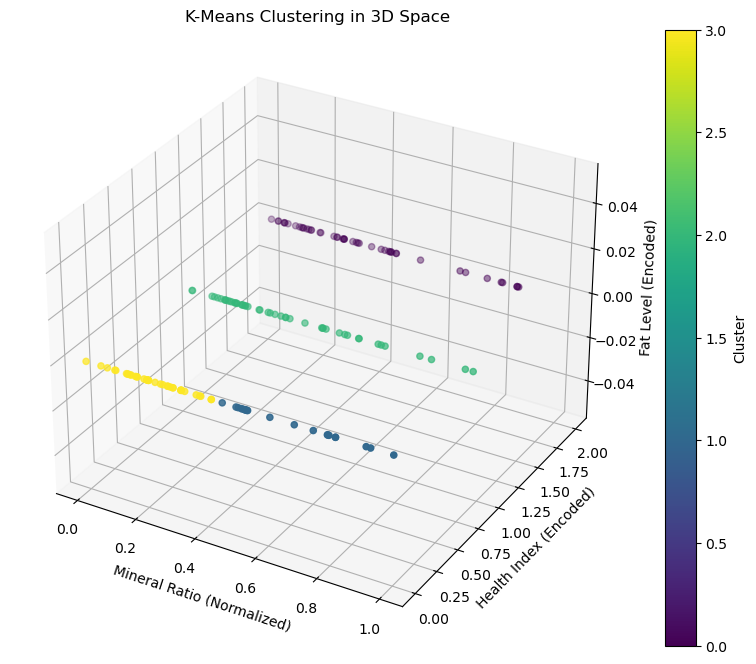

In [15]:


# from sklearn.metrics import accuracy_score

# y_pred_val = best_model.predict(X_val)
# print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(refinedData['Mineral_Ratio'], 
           refinedData['Health_Index'].astype('category').cat.codes,  # Convert categorical to numerical for plotting
           # Convert categorical to numerical for plotting
           c=refinedData['Cluster'], 
           cmap='viridis', 
           marker='o')

# Set labels
ax.set_xlabel('Mineral Ratio (Normalized)')
ax.set_ylabel('Health Index (Encoded)')
ax.set_zlabel('Fat Level (Encoded)')
ax.set_title('K-Means Clustering in 3D Space')

# Show color bar
pl.colorbar(ax.collections[0], label='Cluster')
pl.show()



In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

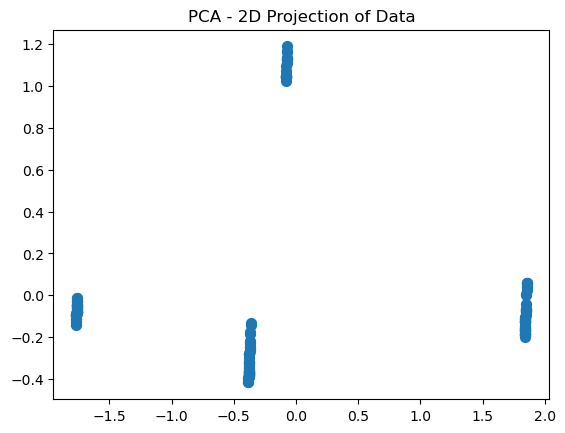

In [17]:
# Apply PCA to reduce dimensions to 2 components for visualization
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(refinedData.drop(columns=['Treatment_Type']))  # Drop the label column

# Visualize PCA-transformed data
pl.scatter(pca_transformed[:, 0], pca_transformed[:, 1], s=50)
pl.title('PCA - 2D Projection of Data')
pl.show()



In [18]:
# Initialize K-Means with k-means++ to improve cluster initialization
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(pca_transformed)

# Predict clusters
refinedData['Cluster'] = kmeans.labels_

# Evaluate the clustering using Silhouette Score (closer to 1 is better)
silhouette_avg = silhouette_score(pca_transformed, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.9584449405301781


In [19]:
# Apply PCA to reduce dimensions to 2 components for visualization
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(refinedData.drop(columns=['Treatment_Type']))  # Drop the label column


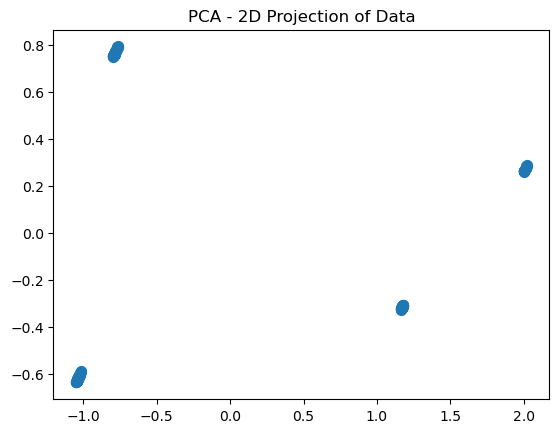

In [20]:
# Visualize PCA-transformed data
pl.scatter(pca_transformed[:, 0], pca_transformed[:, 1], s=50)
pl.title('PCA - 2D Projection of Data')
pl.show()



In [21]:
# Initialize K-Means with K-means++ to improve cluster initialization
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(pca_transformed)

KMeans(n_clusters=4, random_state=42)

In [22]:
# Predict clusters
refinedData['Cluster'] = kmeans.labels_

In [23]:
silhouette_avg = silhouette_score(pca_transformed, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score


Silhouette Score: 0.9891639622554665


In [24]:
X = refinedData[['Health_Index', 'Mineral_Ratio']]
y = refinedData['Treatment_Type']


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [26]:
param_grid = {
    'n_estimators': [100, 200, 500],   # Vary the number of trees
    'max_depth': [None, 10, 20, 30],   # Vary the depth of trees
    'min_samples_split': [2, 5, 10],   # Control when to split a node
    'min_samples_leaf': [1, 2, 4],     # Control the minimum number of samples per leaf node
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}



In [27]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [28]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [29]:
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Predict and evaluate with best parameters
y_pred = grid_search.best_estimator_.predict(X_test)


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [32]:
# Calculate Accuracy and F1-Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Random Forest Accuracy (Tuned): {accuracy}')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score



Random Forest Accuracy (Tuned): 0.7659574468085106


In [38]:
# Encode categorical variables with handling for unseen labels
def safe_encode(column, encoder):
    """Encode a column with LabelEncoder, handling unseen labels."""
    column = column.fillna('Unknown')  # Replace NaN with a placeholder
    encoder.fit(column)  # Fit encoder on the column
    return encoder.transform(column)  # Transform the column


NameError: name 'df_test' is not defined